# Introduction to Deep Learning with Keras - Classification

In the first tutorial notebook we used the Neural Network (NN) as a regression tool. A second large area where Deep Neural Networks are applied is classification. 
Depending on the different classes we want to distinguish, we talk about
 * Binary Classification
 * Multi-Class Classification

We are still in the field of Supervised Learning, but the true values are now **discrete Class Labels**.

In **Binary Classification** the target values are typically $y^{(i)} \in \{0,1\}$,  like "Cats=0" and "Dogs=1", or Background and Signal. 
The dataset consists in this case of the multi-dimensional input vectors $\mathbf{x}^{(i)}$, our data points, together with the true labels $y^{(i)} \in \{0,1\}$.

In order to make the connection between the discrete class label and the continuous NN output, we introduce a probabilistic interpretation of the NN. We assume that the NN represents some probability density $p(\mathbf{x}|\mathbf{w},\mathbf{b})$, and we try to learn this density from the distribution of the labels in our data. 

A single node as last layer with a sigmoid activation function, the **Logistic Function**, is a way to implement this. The logistic function  maps all input into the range $[0,1]$, as it should be for a proper probability.

<img src="img/Activation_logistic.png" width="200" >$f(x)=\frac{1}{1+\exp({-x})}$  


A special loss function is needed for the training of such a network. 
The optimal parameters $\mathbf{w,b}$ can be found by an Maximum Likelihood approach.
The decision between 1/0 is a binomial process (Bernoulli trial), like tossing a coin. 
If we assume that the NN represents a probability estimate 
$\widehat{y}=p(\mathbf{x}|\mathbf{w},\mathbf{b})$, than the probability for being in class 1 will be just $\widehat{y}$, and $1-\widehat{y}$ for being in class 0. For a batch with $n_{batch}$ data points, we multiply the probability for each datapoint

$$\prod_\textrm{k in class 1}^{n_{batch}} \widehat{y}_k 
\cdot \prod_\textrm{k in class 0}^{n_{batch}}(1-\widehat{y}_k) 
= \prod_k^{n_{batch}}  [ y_k \widehat{y}_k + (1-y_k)(1-\widehat{y}_k) ], 
$$

and the -log likelihood becomes:
$$-\frac{1}{n_{batch}}\sum_{i=1}^{n_{batch}}y_i\log(\widehat{y_i})+(1-y_i)\log(1-\widehat{y_i})$$ 


 
This expression is also known as **Cross Entropy**. The name is related to the fact that entropy is defined as the expectation value of log(probability): _Entropy_$\,:=\int log(p)p(x)dx$. If we take the average over some other probability $q(x)$, we talk about cross entropy, _Cross Entropy_$\,:=\int log(p)q(x)dx$. It can be shown that the cross entropy becomes minimal when the two probabilities are identical $p=q$. https://en.wikipedia.org/wiki/Gibbs%27_inequality<br>
In addition, we have normalized by $1/n_{batch}$ that makes it easy to interpret,for example $\frac{1}{n_{batch}}\sum_{i=1}^{n_{batch}}y_i$ as probability for finding class 1 in the batch.

In short, with cross entropy as loss function, the NN learns to model the distribution of the training labels $y^{(i)}$. After the training the NN output $\widehat{y}$ is a number between $[0,1]$. To get a yes/no answer, one typically applies a threshold of $0.5$.
***

### Binary Classification Example 

We create the same toy data as in part 1, but this time we only ask if the output is positive

In [1]:
# We create the same toy data as in part 1, but we only ask if the output is positive
import numpy as np
# We create 10000 random vectors each 10-dim
N_samples=10000
N_in=10
# A matrix N_samplesxN_in, uniform in [0,1)
x_train=np.random.rand(N_samples,N_in)
# Sum of squares along N_in
z = np.sum( np.square(x_train),axis=1)
y_train = (np.sin(z) >= 0).astype(np.int32)

In [2]:
# The first 20 target values
print y_train[:20]

[1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0]


***
We build a simple network to classify our toy data. There are a few things to note.
* The shorthand name in Keras for the logistic function is just `sigmoid`.
* Keras provides a cross entropy loss function for the binary case:<br> 
**losses.BinaryCrossentropy** https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy.
* When we compile the model we also add Accuracy as a **Metric**: `metrics=['acc']`.<br>
A metric is a quality measure, similar to the loss, but it is not used for the learning. 
* We define a validation sample for the fit method: `validation_split=0.2`. This means that 20% of our trainings data will be put aside and only be used for validation. 

**Accuracy** is calculated from the predictions of the trained network. It is defined as the ratio of the correct classified labels (the correct 0s and 1s) over all data. For calculating, Keras must apply a threshold to get a yes/no response, since The NN output $\widehat{y}$ is a number between $[0,1]$. By default the threshold value is $\widehat{y}>0.5$ when calculating the accuracy. 

Also for the fitting, we use additional functionality. When we test the performance of a network on the same dataset as used for training, the result will be over-optimistic. The network typically learns some accidental patterns from the datasets. The performance will not **generalize** to new, unseen data. To check for such **Overtraining**, we calculate the loss and the metric(s) on an independent test sample. https://en.wikipedia.org/wiki/Overfitting

In [3]:
from tensorflow.keras import models, layers, losses, optimizers
# To suppress depraction warnings in some environments
from tensorflow import logging
logging.set_verbosity(logging.ERROR)

model = models.Sequential(
    [
        layers.Dense(100, activation='relu', input_dim=10),
        layers.Dense(100, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)
optimizer = optimizers.Adam()
model.compile(optimizer=optimizer,loss=losses.BinaryCrossentropy(), metrics=['acc'])
histObj = model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.2)
#histObj = model.fit(x_train, y_train, batch_size=256, epochs=100, validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/20
8000/8000 [==============================] - 0s 42us/sample - loss: 0.6530 - acc: 0.5620 - val_loss: 0.6254 - val_acc: 0.5960
Epoch 2/20
8000/8000 [==============================] - 0s 9us/sample - loss: 0.5883 - acc: 0.6731 - val_loss: 0.5362 - val_acc: 0.7825
Epoch 3/20
8000/8000 [==============================] - 0s 9us/sample - loss: 0.4795 - acc: 0.7991 - val_loss: 0.4196 - val_acc: 0.8315
Epoch 4/20
8000/8000 [==============================] - 0s 9us/sample - loss: 0.3758 - acc: 0.8462 - val_loss: 0.3418 - val_acc: 0.8625
Epoch 5/20
8000/8000 [==============================] - 0s 9us/sample - loss: 0.3112 - acc: 0.8766 - val_loss: 0.2930 - val_acc: 0.8850
Epoch 6/20
8000/8000 [==============================] - 0s 9us/sample - loss: 0.2791 - acc: 0.8910 - val_loss: 0.2712 - val_acc: 0.8870
Epoch 7/20
8000/8000 [==============================] - 0s 12us/sample - loss: 0.2523 - acc: 0.9005 - val_loss: 0.2482 - val_acc: 0.898

In [4]:
# We have now 2x2 histories, 
# for the 2 samples, training and validation,
# and for the loss and the accuracy
histObj.history.keys()

['acc', 'loss', 'val_acc', 'val_loss']

### Leraning Curves

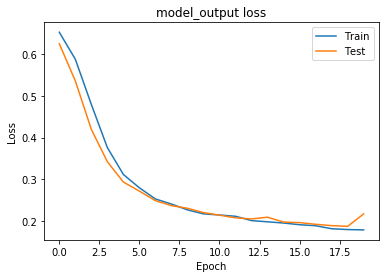

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training & validation loss values over epochs
plt.plot(histObj.history['loss'])
plt.plot(histObj.history['val_loss'])
plt.title('model_output loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Again, the loss drops quickly over the first epochs and then improves only slowly.
Note the peculiarity of the Keras history object: In the first epochs, the test loss is lower than the train loss. We would expect the opposite behavior: a better or at least similar performance on the train data due to overfitting. The reason is that the training loss is computed as the average of the losses over each batch of training data. Because your model is changing over time, the loss over the first batches of an epoch is generally higher than over the last batches. In contrast, the testing loss is calculated using the model as it is at the end of each epoch, resulting in a lower loss. After a few epochs, when the model does not change quickly anymore, and the overtraining becomes larger, we see the expected trend.

The fact that train and test loss do not diverge strongly shows that the chosen model is not too complex for our problem. 

The loss is still falling after 20 epochs. A larger number of epochs will probably improve the training.   
***
The accuracy in the next plot follows mainly the loss improvement. It starts at about 0.5 - even a purely random label would be correct in 50% of the trials. Try!

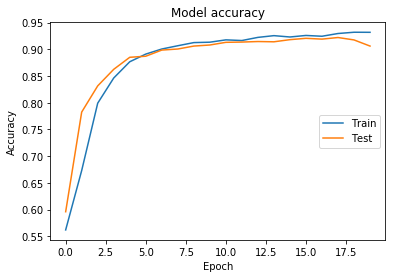

In [9]:
# Plot training & validation accuracy values
plt.plot(histObj.history['acc'])
plt.plot(histObj.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='right')
plt.show()

***
We can evaluate our model on a dataset: `model.evaluate` returns the metric(s) and loss(es) we have provided in the compile step. Note that a larger batch size also speeds up the calculation during prediction!

In [10]:
# We evaluate our model on the complete trainings dataset 
# A larger batch size speeds up the calculations
loss_value, accuracy = model.evaluate(x_train, y_train,batch_size=512)
print(loss_value,accuracy)

10000/10000 [==============================] - 0s 3us/sample - loss: 0.2018 - acc: 0.9149
(0.2018295553445816, 0.9149)


In [11]:
## Uncomment, if you want to test the speed improvements yourself
#%timeit y_pred=model.predict(x_train).reshape(y_train.shape) 
# 1 loop, best of 3: 189 ms per loop - Intel Core i7 2 core 2.5 GHz MacBook Pro
#%timeit y_pred=model.predict(x_train,batch_size=512).reshape(y_train.shape)
# 10 loops, best of 3: 17 ms per loop
## The results maybe differ but only within the numerical presicion
#y_pred_a=model.predict(x_train).reshape(y_train.shape)
#y_pred_b=model.predict(x_train,batch_size=512).reshape(y_train.shape)
#print('numeric identical',np.sum(np.isclose(y_pred_a,y_pred_b)))
y_pred=model.predict(x_train,batch_size=512).reshape(y_train.shape)

In [12]:
# The accuracy calculation by hand
accuracy=np.mean(np.equal(y_train, y_pred>0.5))
print accuracy

0.9149


***
## Multi-Class Classification 

Often a problem consists in identifiying multiple classes or categories. Each datapoint belongs to exactly one class, and the training data is labeled according to the $K$ classes: $y^{(i)}\in\{1,..,K\}$. The classical example is the identification of images from handwritten numbers 0-9. 

The considerations presented above for binary classification can be applied in a similar way to multi-class classification.
Instead of a binomial problem, we have now a multi-nomial problem, and the proper loss function becomes the **Categorical Cross Entropy**.

As in the binary case, we implement a probability interpretation of the NN output. The output layer must be extended to represent the $K$ classes: Instead of the one sigmoid, we must have $K$ nodes with output $z_k$, and we need an activation function that allows a probability interpretation. The appropriate activation function in this case is called **Softmax**:

$f_{k}(\overrightarrow{z})=\frac{\exp({z_{k}})}{\sum_{j=1}^{K} \exp({z_{j}})} \quad \text { for } k=1, \ldots, K$ https://en.wikipedia.org/wiki/Softmax_function

The softmax function is defined in a way that each output node stays within $[0,1]$, as it must be for a probability, and the sum of all outputs is always one ($\sum_k f_k=1$). The predicted class is then the node with the largest softmax output.

In short, for multi-classification we use K nodes with softmax activation and (sparse, see below) categorical cross entropy as loss.



###  Fashion-MNIST

As multi-class example, we take the Fashion-MNIST dataset. This dataset had been become popular in last few years as a benchmark example in image classification. https://github.com/zalandoresearch/fashion-mnist
(Zalando SE is a European e-commerce company based in Berlin selling fashion products.)

Keras knows this dataset and can provides the images (or downloads them on first use).

In [13]:
import tensorflow as tf
dataset = tf.keras.datasets.fashion_mnist

The dataset consists of 60k trainings image and 10k test images. The images are grayscale with 28x28 pixels. There are 10 equal sized categories. 

In [14]:
(x_train, y_train),(x_test, y_test) = dataset.load_data()
print x_train.shape

(60000, 28, 28)


In [15]:
# It is always a good practice to normalize the dataset
x_train, x_test = x_train / 255.0, x_test / 255.0

We print the first 20 labels from this dataset.

In [16]:
print y_train[:20]

[9 0 0 3 0 2 7 2 5 5 0 9 5 5 7 9 1 0 6 4]


A technicallity, Keras provides two versions of categorial cross entropy (CCE) loss. The choice depends on the way how the class labels are represented. There are essentially 2 possibilities: the one-hot-encoding, for example `[0,0,0,1,0,0,0,0,0,0]`, where the position marks the class, or just integer numbers, like '3'. From the previous cell, we see that the latter is used in the fashion-MNIST dataset. The appropriate implementation of the loss function in this case is the sparse CCE.
<br>
https://www.tensorflow.org/api_docs/python/tf/keras/backend/sparse_categorical_crossentropy
***
We define names for the classes, and plot a few training images to get an idea of the data.

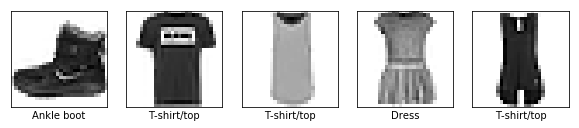

In [17]:
class_names=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

Indeed, fashion items.

### Building the Network
* As in the introduction described, we use a last layer with $K=10$ nodes and the 'softmax' activation together with sparse categorial cross entropy.
* The first layer flattens the images. The 28x28 image is transformed into a 784 vector. There are better ways to handle image data.
* Accuracy as metric is included. There are now 10 categories and a randomly applied label would have a 10% chance to be correct. 
* Note that with a few lines of code we have defined a model with more than half a million of parameters.

In [26]:
from tensorflow.keras import models, layers, losses, optimizers

model = tf.keras.models.Sequential([
  layers.Flatten(input_shape=(28, 28)),
  layers.Dense(512, activation='relu'),
  layers.Dense(512, activation='relu'),
  layers.Dense(10, activation='softmax')
])
model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [27]:
history=model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=256, epochs=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 59us/sample - loss: 0.5025 - acc: 0.8242 - val_loss: 0.4262 - val_acc: 0.8477
Epoch 2/5
60000/60000 [==============================] - 3s 56us/sample - loss: 0.3567 - acc: 0.8703 - val_loss: 0.3912 - val_acc: 0.8586
Epoch 3/5
60000/60000 [==============================] - 3s 57us/sample - loss: 0.3176 - acc: 0.8846 - val_loss: 0.3513 - val_acc: 0.8708
Epoch 4/5
60000/60000 [==============================] - 3s 58us/sample - loss: 0.2890 - acc: 0.8944 - val_loss: 0.3530 - val_acc: 0.8746
Epoch 5/5
60000/60000 [==============================] - 3s 57us/sample - loss: 0.2744 - acc: 0.8986 - val_loss: 0.3315 - val_acc: 0.8783


['acc', 'loss', 'val_acc', 'val_loss']


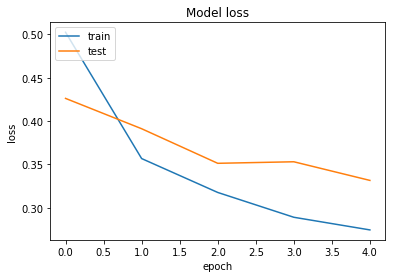

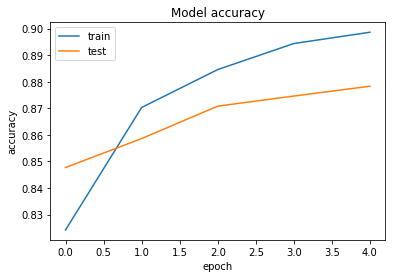

In [28]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

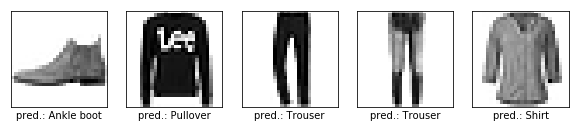

In [29]:
import numpy as np
fiveImages = x_test[0:5]
predictions = model.predict(fiveImages)
predictions = np.argmax(predictions,axis=1)

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fiveImages[i], cmap=plt.cm.binary)
    plt.xlabel('pred.: '+class_names[predictions[i]])
plt.show()

### GPU Usage

In [22]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13414798630152770932
]
